In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
from optuna.distributions import UniformDistribution, CategoricalDistribution, IntUniformDistribution, LogUniformDistribution
from sklearn import svm
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")
AVAILABLE_CLASSIFIER = ["linear_svm", "logistic_regression", "knn", "xgboost"]


# Logistic Regression
CLF_LOGISTIC = LogisticRegression(random_state=42, solver="sag")
HYP_LOGISTIC = {
    "C": UniformDistribution(low=1e-8, high=20.),
    "penalty": CategoricalDistribution(["none", "l2"]),
    "class_weight": CategoricalDistribution([None, "balanced"])
}

def get_classifier(
        classifier_name: str,
        *,
        n_jobs: int = -1
):
    if classifier_name == "logistic_regression":
        classifier, hyperparameters = CLF_LOGISTIC, HYP_LOGISTIC
        classifier.set_params(**{"n_jobs": n_jobs})
    else:
        raise ValueError(f"Classifier {classifier_name} does not exits. Possible values: {AVAILABLE_CLASSIFIER}")

    return classifier, hyperparameters


def execute_optimization(
        classifier_name: str,
        X_train: np.ndarray,
        y_train: np.ndarray,
        *,
        opt_cv: int = 5,
        opt_n_iter: int = 30,
        opt_scoring: str = "f1_macro",
        opt_n_jobs: int = 3,
        clf_n_jobs: int = 10,
        seed: int = 42
) -> BaseEstimator:
    classifier, hyperparameters = get_classifier(classifier_name, n_jobs=clf_n_jobs)
    pipeline = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", classifier)
    ])
    hyperparameters = {f"classifier__{k}": v for k, v in hyperparameters.items()}

    optuna_search = OptunaSearchCV(
        pipeline,
        hyperparameters,
        cv=StratifiedKFold(opt_cv, shuffle=True, random_state=seed),
        error_score="raise",
        n_trials=opt_n_iter,
        random_state=seed,
        scoring=opt_scoring,
        n_jobs=opt_n_jobs
    )
    print("\tExecuting model...", end="")
    optuna_search.fit(X_train, y_train)

    return optuna_search


In [ ]:
DATA_DIR = "/home/welton/data"
PROBS_DIR = f"{DATA_DIR}/clfs_output/split_10/webkb/10_folds/"
LABELS_DIR = f"{DATA_DIR}/datasets/labels/split_10/webkb/"
UPPER_DIR = f"{DATA_DIR}/oracle/upper_bound/webkb/"
CLFS = ["rep_bert", "xlnet_rep", "lfr", "xtmk", "str", "kpr"]

In [ ]:
def load_probs(base_dir, clfs, fold):

    probas = {}
    for clf in clfs:
        probas[clf] = {}
        probas_dir = f"{base_dir}/{clf}/{fold}/"
        train_load = np.load(f"{probas_dir}/train.npz")
        test_load = np.load(f"{probas_dir}/test.npz")

        probas[clf]["X_train"] = train_load["X_train"]
        probas[clf]["X_test"] = test_load["X_test"]
    return probas

def load_y(labels_dir, fold):

    return np.load(f"{labels_dir}/{fold}/train.npy"), np.load(f"{labels_dir}/{fold}/test.npy")

def load_upper(base_dir, clfs, fold):

    upper = {}
    for clf in clfs:
        upper[clf] = {}
        upper_dir = f"{base_dir}/{clf}/{fold}/"
        upper[clf]["y_train"] = np.load(f"{upper_dir}/train.npz")['y']
        upper[clf]["y_test"] = np.load(f"{upper_dir}/test.npz")['y']
    return upper

In [ ]:
probas = load_probs(PROBS_DIR, CLFS, 0)

In [ ]:
y_train, y_test = load_y(LABELS_DIR, 0)

In [ ]:
upper = load_upper(UPPER_DIR, CLFS, 0)

In [ ]:
idxs = np.arange(probas["lfr"]["X_train"].shape[0])
train_idxs, val_idxs = train_test_split(idxs, stratify=y_train, test_size=.1)

In [ ]:
X_train = []
for clf in probas:
    X_train.append(probas[clf]["X_train"][train_idxs] * upper[clf]["y_train"][train_idxs][:, None])
X_train = np.hstack(X_train)

In [ ]:
X_train.shape

In [ ]:
train_labels = y_train[train_idxs]

In [ ]:
optuna_search = execute_optimization("logistic_regression", X_train, train_labels)

## Criando a combinação das probabilidades no espaço de validação.

In [ ]:
val_labels = y_train[val_idxs]

In [ ]:
CLFS, val_labels.shape

In [ ]:
clfs_idx = {clf:idx for idx, clf in enumerate(CLFS)}
clfs_idx

In [ ]:
def get_zero_array(probas):
    return np.zeros(probas["rep_bert"]["X_train"][0].shape[0])

In [ ]:
N = 2 ** 6
N

In [ ]:
truth_table = np.array([[bool(i & (1 << j)) for j in range(6)] for i in range(N)], dtype=bool)
truth_table = np.where(truth_table == 1, 1, 0)
truth_table[:10]

In [ ]:
expanded_docs = {}
# Para cada documento.
for doc_idx in np.arange(val_labels.shape[0]):
    X_docs = []
    for row in truth_table:
        doc_probas = []
        for idx_clf in np.arange(len(CLFS)):
            if row[idx_clf] == 0:
                doc_probas.append(get_zero_array(probas))
            else:
                doc_probas.append(probas[CLFS[idx_clf]]["X_train"][val_idxs][doc_idx])
        X_docs.append(np.hstack(doc_probas))
    expanded_docs[doc_idx] = np.vstack(X_docs)
    

In [84]:
right_preds = {}
docs_scores = []
docs_preds = []

In [85]:
for doc_idx in np.arange(val_labels.shape[0]):
    preds = optuna_search.predict(expanded_docs[doc_idx])
    true_class = val_labels[doc_idx]
    y = np.full(N, true_class, dtype=int)
    docs_scores.append(accuracy_score(y, preds))
    docs_preds.append(preds)

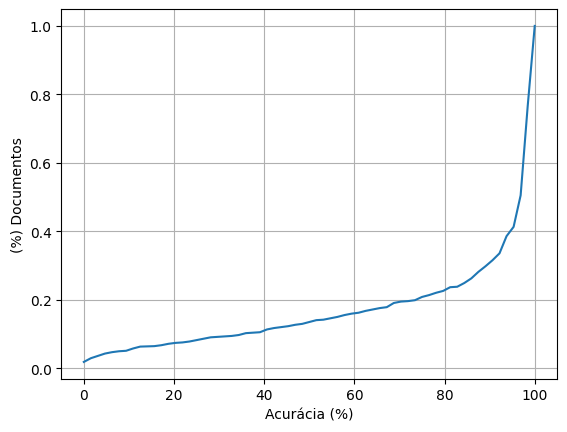

In [86]:
def get_cdf(values):
    counts = pd.Series(values).value_counts()
    keys = sorted(list(counts.keys()))
    acc = 0
    cdf = []
    n_docs = len(values)
    for key in keys:
        acc += counts[key] / n_docs
        cdf.append(acc)
    return keys, cdf

keys, cdf = get_cdf(docs_scores)
plt.plot(np.array(keys) * 100, cdf)
plt.xlabel("Acurácia (%)")
plt.ylabel("(%) Documentos")
plt.grid()

In [90]:
encoder_labels = []
for doc_idx in np.arange(val_labels.shape[0]):
    good_combs = []
    for pred_idx in np.arange(N):
        # Se a combinação de modelos resultou em um acerto da meta-camada.
        if docs_preds[doc_idx][pred_idx] == val_labels[doc_idx]:
            # Adicione essa combinação como um label.
            good_combs.append(truth_table[pred_idx])
    if good_combs:
        encoder_labels.append(np.vstack(good_combs))

In [88]:
encoder_labels[0]

IndexError: list index out of range

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim

def rounding_activation(x):
    return torch.round(torch.clamp(x, 0, 1))

def custom_loss(y_true, y_pred):

    loss = 0
    for idx in range(y_true.shape[0]):
        torch.sub(y_pred[idx], y_pred[idx][:, None])

# Define the class for the neural network encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = rounding_activation(self.fc3(x))
        return x

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the Encoder class
input_size = 
hidden_size = ... # Specify the hidden size
output_size = ... # Specify the output size (N)
encoder = Encoder(input_size, hidden_size, output_size).to(device)

# Specify the optimizer
optimizer = optim.AdamW(encoder.parameters())

# Specify the number of epochs
num_epochs = 30

In [ ]:
# Train the neural network
for epoch in range(num_epochs):
    # ...
    # Move the data and labels to the GPU
    data = data.to(device)
    labels = labels.to(device)
    
    # Compute the loss
    output = encoder(data)
    loss = ...
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Compute the gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()
    
    # Validation step
    with torch.no_grad():
        # Move the validation data to the GPU
        val_data = val_data.to(device)
        val_labels = val_labels.to(device)
        
        # Compute the validation loss
        val_output = encoder(val_data)
        val_loss = ...
    
    # ...

In [ ]:
# Prediction step
with torch.no_grad():
    # Move the test data to the GPU
    test_data = test_data.to(device)
    
    # Compute the predictions
    predictions = encoder(test_data)